# Getting started with PyMC3

Taken from https://docs.pymc.io/notebooks/getting_started.html

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from plotnine import * 
plt.style.use('seaborn-darkgrid')

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Linear regression

In [12]:
# Initialize the random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = (1, 2.5)
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate the outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

# Create a dataframe
df = pd.DataFrame({'Y':Y, 'X1':X1, 'X2':X2})

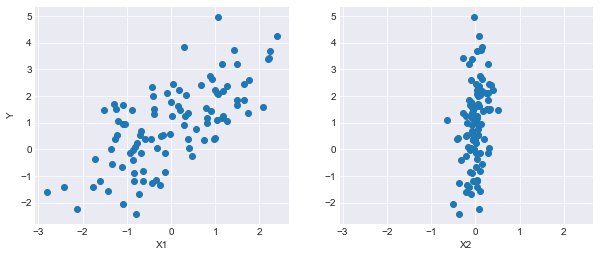

In [13]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2');

In [15]:
basic_model = pm.Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # expected value of outcomes
    mu = alpha + beta[0]*df['X1'] + beta[1]*df['X2']
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=df['Y'])

In [17]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1636.68it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

In [23]:
with basic_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 4041.60draws/s]


In [24]:
trace['alpha'][-5:]

array([1.01312614, 1.04564254, 0.95339452, 1.07952005, 0.70275107])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c193d6c18>,
      dtype=object)

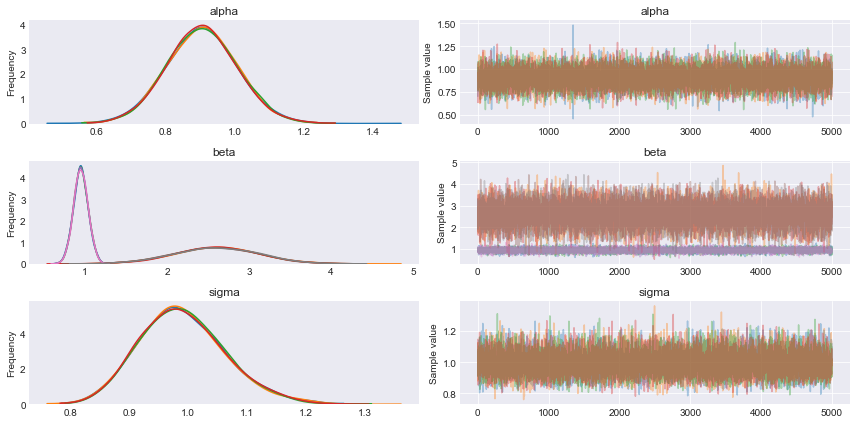

In [25]:
pm.traceplot(trace)

In [26]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.0,0.71,1.10,33251.79,1.0
beta__0,0.95,0.09,0.0,0.77,1.12,32496.54,1.0
beta__1,2.60,0.51,0.0,1.59,3.60,30745.62,1.0
sigma,0.99,0.07,0.0,0.85,1.14,28664.47,1.0


## Stochastic volatility

In [27]:
returns = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=True, index_col=0)

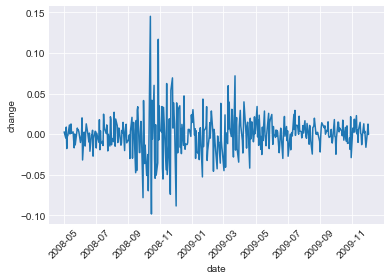

In [40]:
sns.lineplot(x='date', y='change', data=returns.reset_index())
plt.xticks(rotation=45);

In [42]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)
    
    s = pm.GaussianRandomWalk('s', sd=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)
    
    r = pm.StudentT('r', nu=nu, sd=volatility_process, observed=returns['change'])

In [43]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:45<00:00, 25.61draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x100dba0b8>,
      dtype=object)

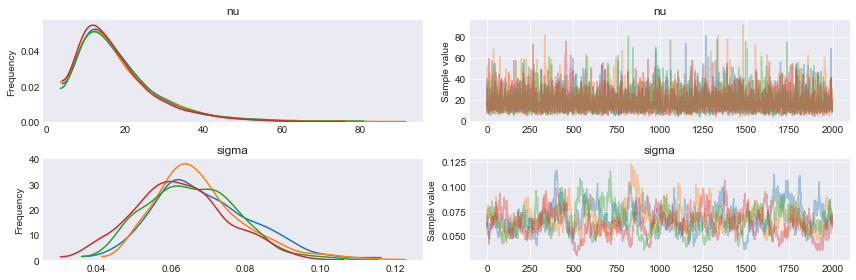

In [44]:
pm.traceplot(trace, varnames=('nu', 'sigma'))

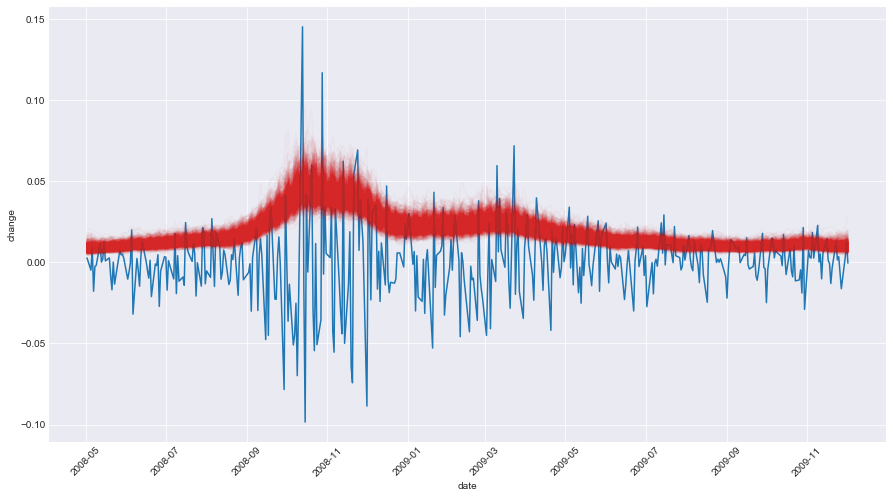

In [47]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(x='date', y='change', data=returns.reset_index())
plt.xticks(rotation=45)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'C3', alpha=0.03);

## Coal mining disasters

In [48]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
years = np.arange(1851, 1962)

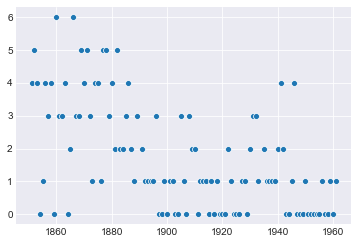

In [51]:
sns.scatterplot(years, disaster_data)

In [52]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(),
                                    testval=1900)
    
    # Priors for pre- and post-switch rates
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)
    
    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    
    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

/anaconda3/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


In [53]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3710.83draws/s]
The number of effective samples is smaller than 10% for some parameters.


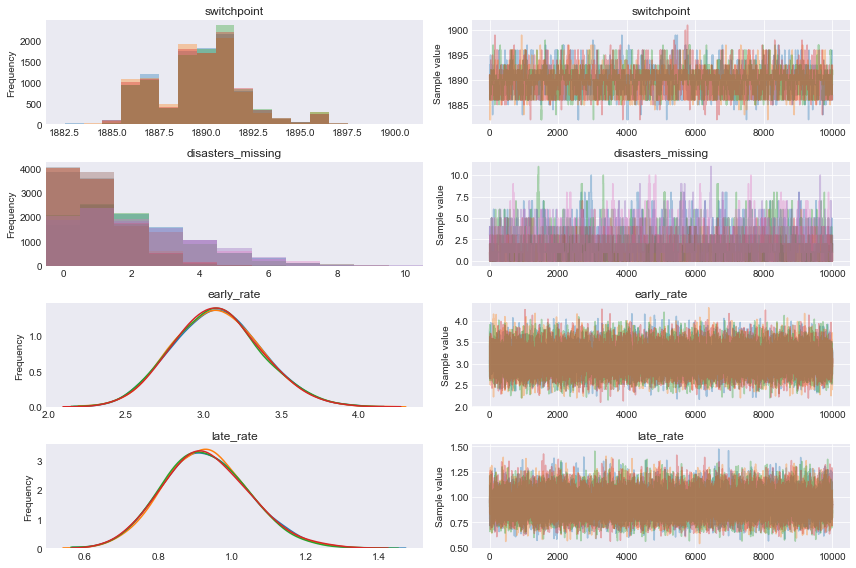

In [54]:
pm.traceplot(trace);

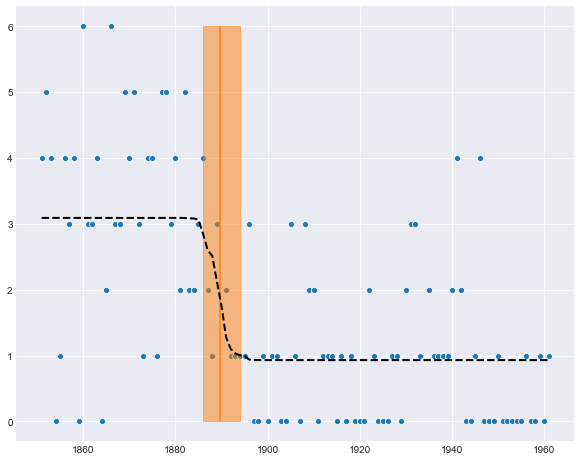

In [62]:
plt.figure(figsize=(10,8))
sns.scatterplot(years, disaster_data)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);